# Mortgage Document Enrichment

---

## Setup Notebook

We will be using the [Amazon Textract Parser Library](https://github.com/aws-samples/amazon-textract-response-parser/tree/master/src-python) for parsing through the Textract response, data science library [Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) for content analysis, the [Amazon SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/), and [AWS boto3 python sdk](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) to work with Amazon Textract and Amazon A2I. Let's now install and import them.

In [ ]:
!python -m pip install -q amazon-textract-overlayer --force-reinstall

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
amazon-textract-prettyprinter 0.1.10 requires amazon-textract-response-parser<0.2,>=0.1, but you have amazon-textract-response-parser 1.0.3 which is incompatible.
astropy 6.1.0 requires numpy>=1.23, but you have numpy 1.22.4 which is incompatible.
awscli 1.34.16 requires botocore==1.35.16, but you have botocore 1.35.28 which is incompatible.
scikit-image 0.24.0 requires numpy>=1.23, but you have numpy 1.22.4 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.2 which is incompatible.
sphinx 8.0.2 requires docutils<0.22,>=0.20, but you have docutils 0.16 which is incompatible.


In [ ]:
from textractcaller.t_call import call_textract, Textract_Features, Textract_Types
from textractprettyprinter.t_pretty_print import Textract_Pretty_Print, get_string, Pretty_Print_Table_Format
from trp.trp2 import TDocument

In [ ]:
import boto3
import botocore
import sagemaker
import os
import io
import datetime
import json
import pandas as pd
from PIL import Image as PImage, ImageDraw
from pathlib import Path
import multiprocessing as mp
from IPython.display import Image, display, HTML, JSON, IFrame
from trp import Document

# variables
data_bucket = sagemaker.Session().default_bucket()
region = boto3.session.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

os.environ["BUCKET"] = data_bucket
os.environ["REGION"] = region
role = sagemaker.get_execution_role()

print(f"SageMaker role is: {role}\nDefault SageMaker Bucket: s3://{data_bucket}")

s3=boto3.client('s3')
textract = boto3.client('textract', region_name=region)
comprehend=boto3.client('comprehend', region_name=region)


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/base_serializers.py:28: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.22.4)
  import scipy.sparse


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
SageMaker role is: arn:aws:iam::842675974990:role/service-role/AmazonSageMaker-ExecutionRole-20240919T022017
Default SageMaker Bucket: s3://sagemaker-us-east-1-842675974990


---
## Redact PII in Paystub

In this step we will first detect PII (Personally Identifiable Information) in the Paystub document. We will then obtain the bounding box information for the detected PII entities and create redaction bounding boxes on the document.

In order to obtain the bounding box geometry of all words from the document we will use a tool called `amazon-textract-overlayer`. See [documentation](https://github.com/aws-samples/amazon-textract-textractor/tree/master/overlayer) for learn more about `amazon-textract-overlayer`.

The un-redacted document looks like below-

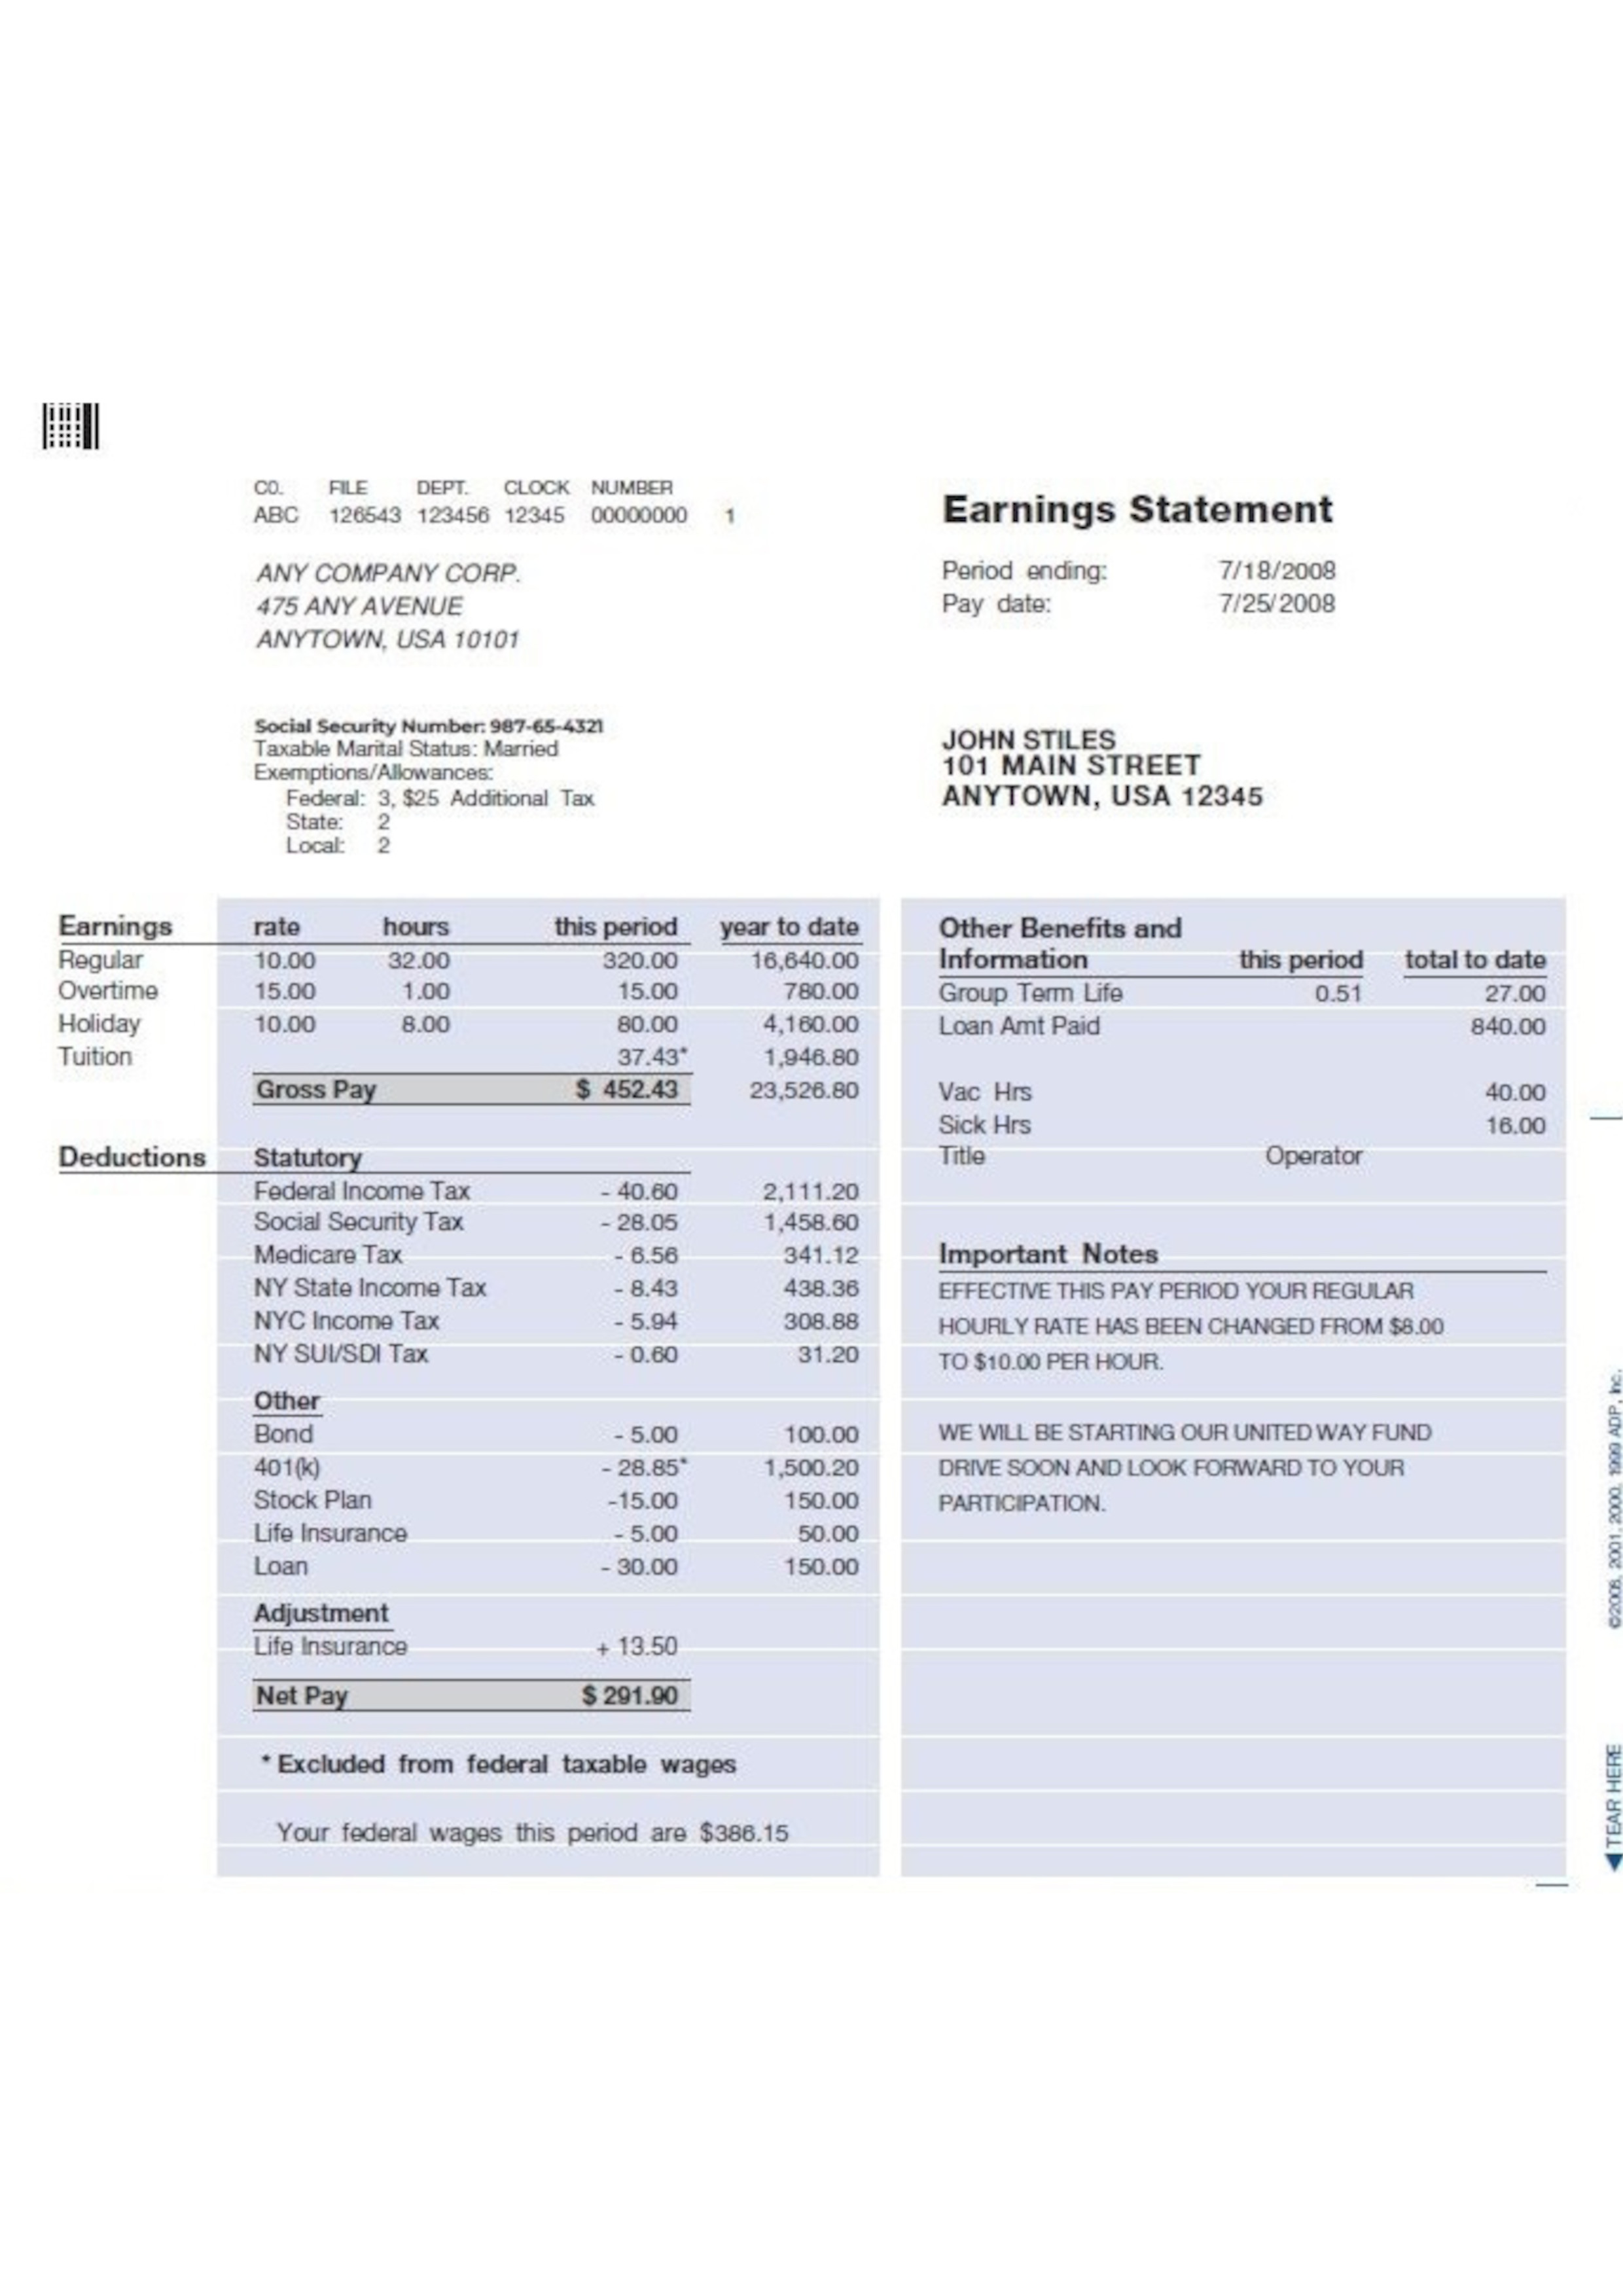

In [ ]:
documentName = "docs/Paystub.png"
display(Image(filename=documentName, width=500))

## NOTE: ACTION IS REQUIRED OUTSIDE OF THE NOTEBOOK FOR THE NEXT CODE CELL TO WORK

You need to grant your SageMaker-Execution-Role Comprehend access for the next line to work.

The easiest way to do this is via the AWS IAM Console. Select your SageMakerExexcutionRole and add Comprehend full access.

### Detecting PII Entities

Let's take a look at how to detect PII entities using Amazon Comprehend Detect PII Entities API. Amazon Comprehend's PII detection API uses a pre-trained NLP model that can detect most common PII entities such as NAME, ADDRESS, SSN, BANK A/C NUMBERS, DATES and so on (for a full list see [documentation](https://docs.aws.amazon.com/comprehend/latest/dg/how-pii.html#how-pii-types)).

In [ ]:
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

resp = call_textract(input_document = imageBytes)
text = get_string(textract_json=resp, output_type=[Textract_Pretty_Print.LINES])

#Call Amazon Comprehend Detect PII Entities API
entity_resp = comprehend.detect_pii_entities(Text=text, LanguageCode="en")

pii = []
for entity in entity_resp['Entities']:
    pii_entity={}
    pii_entity['Type'] = entity['Type']
    pii_entity['Text'] = text[entity['BeginOffset']:entity['EndOffset']]
    pii.append(pii_entity)
pii

[{'Type': 'DATE_TIME', 'Text': '7/18/2008'},
 {'Type': 'DATE_TIME', 'Text': '7/25/2008'},
 {'Type': 'ADDRESS', 'Text': 'ANYTOWN, USA 10101'},
 {'Type': 'SSN', 'Text': '987-65-4321'},
 {'Type': 'NAME', 'Text': 'JOHN STILES'},
 {'Type': 'ADDRESS', 'Text': '101 MAIN STREET'},
 {'Type': 'ADDRESS', 'Text': 'ANYTOWN, USA 12345'},
 {'Type': 'UK_UNIQUE_TAXPAYER_REFERENCE_NUMBER', 'Text': '2,111.20'},
 {'Type': 'UK_UNIQUE_TAXPAYER_REFERENCE_NUMBER', 'Text': '28.05'},
 {'Type': 'UK_UNIQUE_TAXPAYER_REFERENCE_NUMBER', 'Text': '6.56\n341.12'},
 {'Type': 'UK_UNIQUE_TAXPAYER_REFERENCE_NUMBER', 'Text': '8.43\n438.36'},
 {'Type': 'UK_UNIQUE_TAXPAYER_REFERENCE_NUMBER', 'Text': '5.94\n308.88'},
 {'Type': 'ADDRESS', 'Text': '401(k)\n28.85*\n1,500.20\nDRIVE'}]

---
### Perform Document Enrichment

Using a combination of Amazon Comprehend and Amazon Textract we can now perform some PII redaction on a Paystub document. Next we will define a helper function that will

1. Call Amazon Textract to get the plain text information from the Paystub and the corresponding bounding box information since it is an image file
2. Use the extracted text to call Amazon Comprehend's [Detect PII](https://docs.aws.amazon.com/comprehend/latest/dg/how-pii.html) API
3. Use Python Pillow library to draw bounding box redactions on the original document
4. Save the new enriched document with redactions to the file system

In [ ]:
from textractoverlayer.t_overlay import DocumentDimensions, get_bounding_boxes

def redact_doc(localpath, redact_entities):
    try:
        img = PImage.open(localpath)
        draw = ImageDraw.Draw(img)

        # Use call_textract to get bounding boxes
        # call_textract without the features parameter uses Textract Detect text
        with open(localpath, 'rb') as document:
            imageBytes = bytearray(document.read())

        resp = call_textract(input_document = imageBytes)
        document_dimension:DocumentDimensions = DocumentDimensions(doc_width=img.size[0], doc_height=img.size[1])
        overlay=[Textract_Types.LINE, Textract_Types.WORD, Textract_Types.FORM, Textract_Types.CELL, Textract_Types.KEY, Textract_Types.VALUE]
        bounding_box_list = get_bounding_boxes(textract_json=resp, document_dimensions=[document_dimension], overlay_features=overlay)

        print('Detecting entities...')

        text = get_string(textract_json=resp, output_type=[Textract_Pretty_Print.LINES])

        #detect PII Entities
        entity_resp = comprehend.detect_pii_entities(Text=text, LanguageCode="en")

        entities = []
        for entity in entity_resp['Entities']:
            pii_entity={}
            pii_entity['Type'] = entity['Type']
            pii_entity['Text'] = text[entity['BeginOffset']:entity['EndOffset']]
            entities.append(pii_entity)
        redactions = []

        #collect the bounding boxes for the custom entities
        for entity in entities:
            entity_text = entity['Text']
            entity_type = entity['Type']
            for bbox in bounding_box_list:
                if bbox.text == entity_text and entity_type in redact_entities:
                    print(f'Found Entity: {entity_text}')
                    redactions.append(bbox)

        #Perform redaction
        for box in redactions:
            draw.rectangle(xy=[box.xmin, box.ymin, box.xmax, box.ymax], fill="Black")

        #Generate the redacted/enriched document file and save to file system
        opfile = Path(localpath).stem
        opfile = f'{opfile}_redacted.png'
        img.save(opfile)
        print(f'Done.... Redacted file saved: {opfile}')
        return opfile
    except Exception as e:
        print(e)

Now we can call this method and pass it the PII Entities we wish to perform redaction on. In this case, we will pass `NAME`, `SSN`, and `DATE_TIME` for redaction.

In [ ]:
redact_doc('docs/Paystub.png',['NAME','SSN','DATE_TIME'])

Detecting entities...
Found Entity: 7/18/2008
Found Entity: 7/18/2008
Found Entity: 7/25/2008
Found Entity: 7/25/2008
Found Entity: 987-65-4321
Found Entity: JOHN STILES
Done.... Redacted file saved: Paystub_redacted.png


'Paystub_redacted.png'

---
#### Side-by-side comparison of un-redacted vs. redacted document.

In [ ]:
bank_document_local='docs/Paystub.png'
redacted_file='Paystub_redacted.png'

print(f'\nUnredacted Document\t\t\t\t\t\t\tRedacted Document \n')

HTML(f"""
    <div class="row">
            <img src={bank_document_local} style="width:45%"></img>
            <img src={redacted_file} style="width:45%">  </img>
    </div>
    """)


Unredacted Document							Redacted Document 



---
# Conclusion

In this notebook, we saw how we can perform document enrichment such as redacting PII information. We first detected PII entities in the document using Amazon comprehend's detect PII API. Once we were able to detect PII infromation in the document, we used Amazon Textract to obtain the bounding box information for the information that needs to be treated as a PII info and then we finally drew bounding box redactions on the document using an image library.

# Assignment Question #6

In pseudo-code briefly note the steps that needed to convert a submitted document to a redacted version of the document.


(add your answer in the markdown cell that follows)


1. Load the document

with open('path/to/document.png', 'rb') as document:
    imageBytes = bytearray(document.read())
    
2. Extract Text and Bounding Boxes Using Amazon Textract:

resp = call_textract(input_document=imageBytes)
bounding_box_list = get_bounding_boxes(textract_json=resp, document_dimensions=[document_dimension], overlay_features=[Textract_Types.WORD])

3. Detect PII Entities Using Amazon Comprehend:

text = get_string(textract_json=resp, output_type=[Textract_Pretty_Print.LINES])
entity_resp = comprehend.detect_pii_entities(Text=text, LanguageCode="en")

4. Match PII Entities with Bounding Boxes:

for entity in entity_resp['Entities']:
    for bbox in bounding_box_list:
        if bbox.text == entity['Text']:
            redactions.append(bbox)
            
5. Draw Redaction Boxes Over PII Entities:

img = PImage.open('path/to/document.png')
draw = ImageDraw.Draw(img)
for box in redactions:
    draw.rectangle(xy=[box.xmin, box.ymin, box.xmax, box.ymax], fill="Black")
    
6. Saving of redacted document

img.save('path/to/redacted_document.png')

7. Compare Un-Redacted vs. Redacted Documents:Display un-redacted and redacted documents

display_side_by_side('path/to/document.png', 'path/to/redacted_document.png')




# Assignment Question #7 (Optional)

The code above shows the redaction processing of a payslip document ("docs/Paystub.png").

Using one of more of the example documents in the folder "extras/document-samples', redact target data fields of your choice, using the same or similar method.

(add your code and the results in one or more cells that follow)